# **Extraction des Images de fleurs en utilisant Selenium**

**Notre but est de collecter une base de données qui contient différentes images de différents types de fleurs à partir de Google Image en utilisant Selenium**.
- Notre programme doit prendre n'importe quel mot clé (par exemple : "Tulipe"), ainsi que le nombre d'images nécessaires, et récupérer ce nombre d'images depuis Google Images sur le navigateur Chrome.
- Les images doivent être stockées dans un dossier, nommé d'après le terme de recherche, et doivent être numérotées correctement afin de  rendre l'accès et l'interprétation plus faciles.


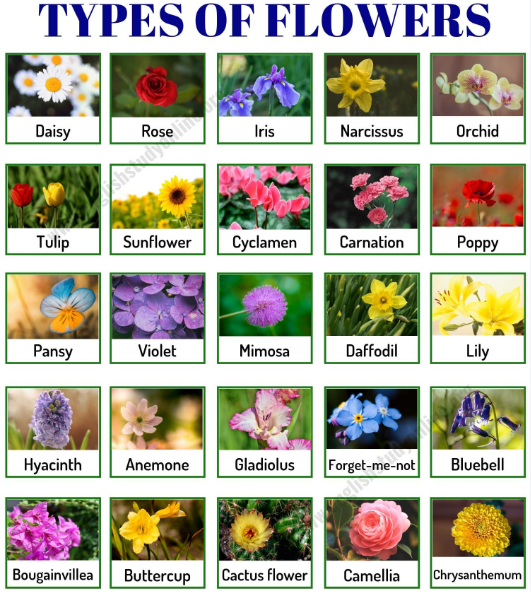

**Setup & tools:**

**Install Selenium , chromdriver**

In [ ]:
!sudo add-apt-repository ppa:saiarcot895/chromium-beta
!sudo apt remove chromium-browser
!sudo snap remove chromium
!sudo apt install chromium-browser
!pip install selenium-stealth
!pip3 install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')


In [ ]:
!pip install webdriver_manager

- You can find complete documentation on selenium here:https://selenium-python.readthedocs.io/. Documentation is very much self-explanatory so make sure to read it to leverage selenium with Python.



**Importer des bibliothèques**

In [3]:
import os
import selenium
from selenium import webdriver
import time
from PIL import Image
import io
import requests
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium_stealth import stealth

**Install Driver**

In [4]:
#Install driver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
driver =webdriver.Chrome('chromedriver',chrome_options=chrome_options)
stealth(driver,
              languages=["fr-FR", "fr"],
              vendor="Google Inc.",
              platform="Win32",
              webgl_vendor="Intel Inc.",
              renderer="Intel Iris OpenGL Engine",
              fix_hairline=True,
          )

<ipython-input-4-ab540a47837e>:6: DeprecationWarning: use options instead of chrome_options
  wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
<ipython-input-4-ab540a47837e>:7: DeprecationWarning: use options instead of chrome_options
  driver =webdriver.Chrome('chromedriver',chrome_options=chrome_options)


**Scroll jusqu'à la fin de la page**
- This line of code would help us to reach the end of the page. And then we’re giving sleep time of 5 seconds so we don’t run in problem, where we’re trying to read elements from the page, which is not yet loaded.

In [5]:
def scroll_to_end(driver):
    driver.execute_script("window.scrollTo(0,document.body.scrollHeight);")
    time.sleep(5)

**Importer les URL des images**
- Nous devons d'abord spécifier l'URL de recherche
- nous allons utilisé l'URL de google image 

- Ensuite, nous recherchons un type de fleurs dans notre URL de recherche. Collez le lien dans la fonction driver.get(" Your Link Here ") et exécutez la cellule. Cela ouvrira une nouvelle fenêtre de navigateur pour ce lien.
- Ensuite, nous devons localiser les images à extraire de la page à l'aide de la méthode driver.find_elements.

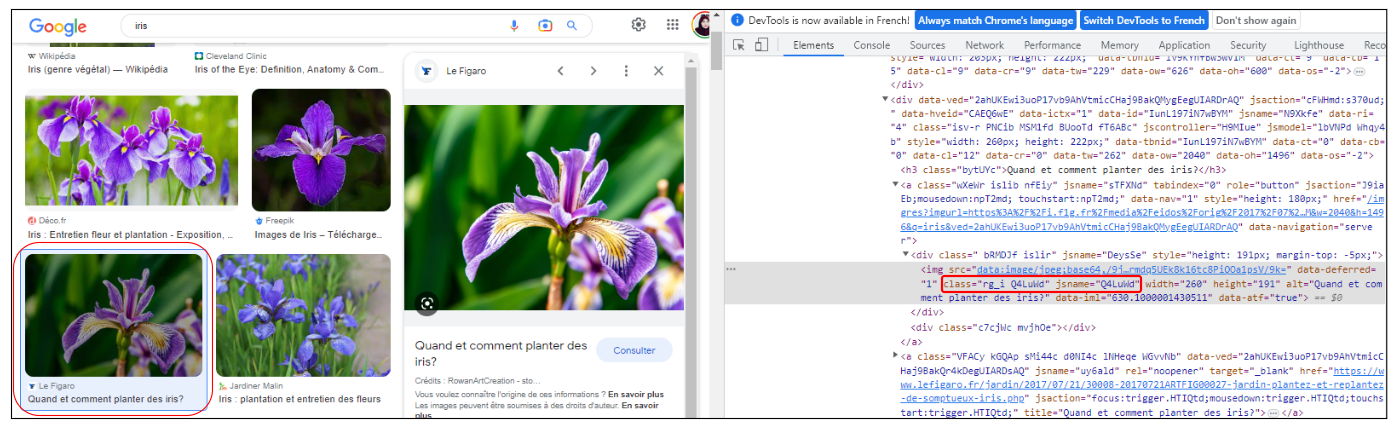

- Nous allons maintenant récupérer tous les liens d'images présents sur cette page. Nous allons créer une "liste" pour stocker ces liens. Pour ce faire, allez dans la fenêtre du navigateur, faites un clic droit sur la page et sélectionnez "inspecter l'élément" ou activez les outils de développement en utilisant Ctrl+Shift+I.

- Identifiez maintenant les attributs tels que la classe, l'identifiant, etc. qui sont communs à toutes ces images.

- Dans notre cas, la classe ="'Q4LuWd" est commune à toutes ces images.

 **Extraire le lien correspondant à chaque image**
 
- Ainsi, pour télécharger chaque image, nous devons cliquer sur chaque thumbnail  et extraire les informations pertinentes correspondant à cette image.

- Dans l'extrait de code ci-dessous, nous effectuons les tâches suivantes...

    - Parcourir chaque  thumbnail et cliquer dessus.
    - Faire dormir notre navigateur pendant 2 secondes (:P).
    - Trouver la balise HTML unique correspondant à cette image pour la localiser sur la page.
    - Nous obtenons toujours plus d'un résultat pour une image donnée.  Mais ce qui nous intéresse, c'est le lien de téléchargement de cette image.
    - Nous parcourons donc chaque résultat pour cette image et en extrayons l'attribut "src", puis nous vérifions si "https" est présent dans le "src" ou non. En effet, les liens web commencent généralement par "https".

- Vous pouvez consulter ce lien pour compléter les trous de codes : https://selenium-python.readthedocs.io/locating-elements.html#locating-by-id

**TO DO**

In [6]:
def getImageUrls(name,totalImgs,driver):
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"
    driver.get(search_url.format(q=name))


    img_urls = set()
    img_count = 0
    results_start = 0  
    
    while(img_count<totalImgs): #Extract actual images now
        
        scroll_to_end(driver)
        thumbnail_results=driver.find_elements(By.CLASS_NAME,'Q4LuWd')
        totalResults=len(thumbnail_results)
        print(f"Found: {totalResults} search results. Extracting links from {results_start}:{totalResults}")
        
        for img in thumbnail_results[results_start:totalResults]:
            
            img.click()
            time.sleep(2)
            actual_images = driver.find_elements("css selector",'img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'https' in actual_image.get_attribute('src'):
                    img_urls.add(actual_image.get_attribute('src'))
            
            img_count=len(img_urls)
            
            if img_count >= totalImgs:
                print(f"Found: {img_count} image links")
                break
            else:
                print("Found:", img_count, "looking for more image links ...")
                load_more_button=driver.find_elements(By.CLASS_NAME,'mye4qd')                
                driver.execute_script("document.querySelector('.mye4qd').click();")
                results_start = len(thumbnail_results)
    return img_urls

**Écrire une fonction pour télécharger chaque image**

In [7]:
def downloadImages(folder_path,file_name,url):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - COULD NOT DOWNLOAD {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        
        file_path = os.path.join(folder_path, file_name)
        
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SAVED - {url} - AT: {file_path}")
    except Exception as e:

        print(f"ERROR - COULD NOT SAVE {url} - {e}")

In [8]:
searchNames=["Alstroemeria","Daisy","Rose","Iris","Narcissus","Orchid","Tulip","Sunflower","Cyclamen","Carnation","Poppy","Violet","Mimosa"]

**Écrire une fonction pour enregistrer chaque image dans le répertoire de destination**

In [9]:
def saveInDestFolder(searchNames,destDir,totalImgs,driver):
    for name in list(searchNames):
        path=os.path.join(destDir,name)
        if not os.path.isdir(path):
            os.mkdir(path)
        print('Current Path',path)
        totalLinks=getImageUrls(name,totalImgs,driver)
        print('totalLinks',totalLinks)

        if totalLinks is None:
            print('images not found for :',name)
            continue
        else:
            for i, link in enumerate(totalLinks):
                file_name = f"{i:150}.jpg"
                downloadImages(path,file_name,link)
            
destDir=f'/content/'

totalImgs=10

saveInDestFolder(searchNames,destDir,totalImgs,driver)

Current Path /content/Alstroemeria
Found: 100 search results. Extracting links from 0:100
Found: 1 looking for more image links ...
Found: 2 looking for more image links ...
Found: 3 looking for more image links ...
Found: 4 looking for more image links ...
Found: 5 looking for more image links ...
Found: 6 looking for more image links ...
Found: 6 looking for more image links ...
Found: 7 looking for more image links ...
Found: 8 looking for more image links ...
Found: 9 looking for more image links ...
Found: 10 image links
totalLinks {'https://www.anniesannuals.com/signs/a/images/alstroemeria_ligtu_prop_space_02.jpg', 'https://bloomsbythebox.sirv.com/img/product/xlarge/01968B__Alstroemeria_Lavender.jpg', 'https://florabundance.com/wp-content/uploads/2018/03/Pink-Alstroemeria-scaled-e1589582480299.jpg', 'https://www.cascadefloralwholesale.com/wp-content/uploads/2018/03/ALSTLPI.jpg', 'https://edelweissperennials.blob.core.windows.net/gallery/0001685_alstroemeria-adonis.jpeg', 'https:/

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


SAVED - https://htmlcolorcodes.com/assets/images/colors/light-violet-color-solid-background-1920x1080.png - AT: /content/Violet/                                                                                                                                                     2.jpg
ERROR - COULD NOT SAVE https://www.apyart.com/3005-large_default/violet-pur.jpg - cannot identify image file <_io.BytesIO object at 0x7fe5bc717a90>
SAVED - https://paintinggal.com/wp-content/uploads/2022/06/purple-vs-violet-1024x703.png - AT: /content/Violet/                                                                                                                                                     4.jpg
SAVED - https://upload.wikimedia.org/wikipedia/commons/a/a3/Color_icon_violet.png - AT: /content/Violet/                                                                                                                                                     5.jpg
SAVED - https://upload.wikimedia.org/wikiped